## 203: Exampville Mode Choice Logsums

Welcome to Exampville, the best simulated town in this here part of the internet!

Exampville is a demonstration provided with Larch that walks through some of the 
data and tools that a transportation planner might use when building a travel model. 

In [1]:
import larch, numpy, pandas, os
from larch import P, X

┌── LARCH 5.2.11 ───────────────────────────────────────────────────
│Python 3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
│[Clang 4.0.1 (tags/RELEASE_401/final)]
│EXE ─ /Users/jpn/anaconda/envs/greenhouse/bin/python
│CWD ─ /Users/jpn/Larch/Larch/larch/doc/example
│PTH ┬ /Users/jpn/Larch/Larch/larch/doc/example
│    ├ /Users/jpn/anaconda/envs/greenhouse/lib/python37.zip
│    ├ /Users/jpn/anaconda/envs/greenhouse/lib/python3.7
│    ├ /Users/jpn/anaconda/envs/greenhouse/lib/python3.7/lib-dynload
│    ├ 
│    ├ /Users/jpn/anaconda/envs/greenhouse/lib/python3.7/site-packages
│    ├ /Users/jpn/Git/filez
│    ├ /Users/jpn/Git/xmle
│    ├ /Users/jpn/Git/addict_yaml
│    ├ /Users/jpn/Larch/Larch
│    ├ /Users/jpn/Git/figured
│    ├ /Users/jpn/Git/madison
│    ├ /Users/jpn/Git/mapped
│    ├ /Users/jpn/anaconda/envs/greenhouse/lib/python3.7/site-packages/IPython/extensions
│    └ /Users/jpn/.ipython
└───────────────────────────────────────────────────────────────────────────
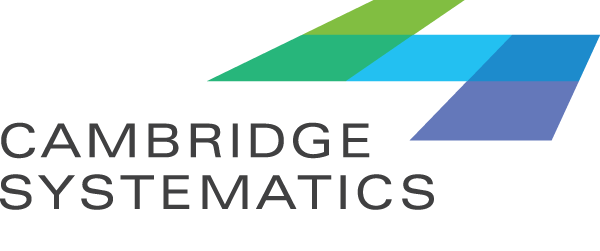
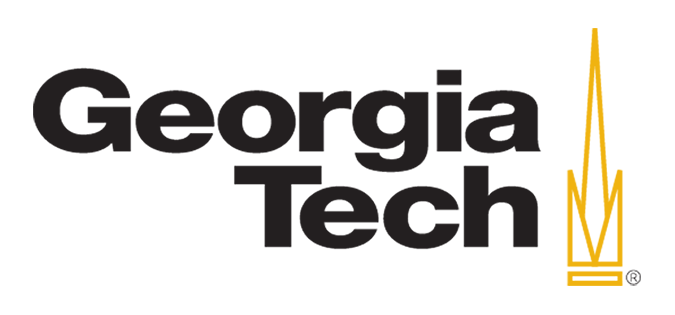

In [2]:
larch.info

In this example notebook, we will walk through the creation of logsums from
an existing tour mode choice model.  First, let's load the data files from
our example.

In [3]:
hh, pp, tour, skims = larch.example(200, ['hh', 'pp', 'tour', 'skims'])

We'll also load the saved model from the mode choice estimation.

In [4]:
exampville_mode_choice_file = larch.example(201, output_file='/tmp/exampville_mode_choice.html')
m = larch.read_metadata(exampville_mode_choice_file)

We'll replicate the pre-processing used in the mode choice estimation,
to merge the household and person characteristics into the tours data,
add the index values for the home TAZ's, filter to include only 
work tours, and merge with the level of service skims.  (If this 
pre-processing was computationally expensive, it would probably have
been better to save the results to disk and reload them as needed,
but for this model these commands will run almost instantaneously.)

In [5]:
raw = tour.merge(hh, on='HHID').merge(pp, on=('HHID', 'PERSONID'))
raw["HOMETAZi"] = raw["HOMETAZ"] - 1
raw["DTAZi"] = raw["DTAZ"] - 1
raw = raw[raw.TOURPURP == 1]
raw = raw.join(
    skims.get_rc_dataframe(
        raw.HOMETAZi, raw.DTAZi,
    )
)

Then we bundle the raw data into the `larch.DataFrames` structure,
as we did for estimation, and attach this structure to the model
as its `dataservice`.

In [6]:
# For clarity, we can define numbers as names for modes
DA = 1
SR = 2
Walk = 3
Bike = 4
Transit = 5

In [7]:
dfs = larch.DataFrames(
    co=raw, 
    alt_codes=[DA,SR,Walk,Bike,Transit], 
    alt_names=['DA','SR','Walk','Bike','Transit'],
    ch_name='TOURMODE',
)

m.dataservice = dfs

We'll also initialize a DataFrame to hold the computed logsums.
This data will have one row for each case in our source data,
and a column for each possible destination zone.

In [8]:
logsums = pandas.DataFrame(
    data=0.0,
    index=raw.index, 
    columns=skims.TAZ_ID
)

The logsums from a Model can be computed using the `Model.logsums` method.
However, if we want the logsums for each possible destination, we'll need
to replace the part of our data that depends on the destination zone, 
writing in the appropriate values for each.  We can simply iterate over the
zones, which is a little bit slow but easy to code.  This isn't a big 
deal, as generating the logsums only needs to be done once after the 
mode choice model is finalized.

In [9]:
for destination_i, dtaz in enumerate(logsums.columns):
    # Get the LOS data for this destination
    new_data = skims.get_rc_dataframe(
        raw.HOMETAZi, destination_i,
    )
    # Write this data into the model's dataservice.
    dfs.data_co[new_data.columns] = new_data
    # Loading this data runs the pre-processing on
    # the dataservice, to create the arrays needed
    # for computation.
    m.load_data()
    # Lastly, compute the logsums and save them
    # to the new DataFrame.
    logsums[dtaz] = m.logsums()


In [10]:
logsums.head()

TAZ_ID,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
0,-1.022226,-0.957339,-2.826200,-1.218908,-1.185637,-1.612774,-1.483605,-0.749422,-1.723349,-1.031615,...,0.166803,-0.531097,-0.854099,-1.066335,-2.256667,-1.920087,-0.850032,-0.982890,-1.043057,-0.406837
2,-1.024910,-0.960130,-2.829841,-1.221681,-1.188343,-1.617506,-1.486384,-0.752037,-1.726272,-1.034435,...,0.157453,-0.533791,-0.856763,-1.070268,-2.260030,-1.925594,-0.852653,-0.985532,-1.046685,-0.409811
4,-1.024910,-0.960130,-2.829841,-1.221681,-1.188343,-1.617506,-1.486384,-0.752037,-1.726272,-1.034435,...,0.157453,-0.533791,-0.856763,-1.070268,-2.260030,-1.925594,-0.852653,-0.985532,-1.046685,-0.409811
5,-1.024910,-0.960130,-2.829841,-1.221681,-1.188343,-1.617506,-1.486384,-0.752037,-1.726272,-1.034435,...,0.157453,-0.533791,-0.856763,-1.070268,-2.260030,-1.925594,-0.852653,-0.985532,-1.046685,-0.409811
8,-0.949999,-0.882285,-2.729509,-1.144347,-1.112798,-1.486712,-1.408887,-0.678955,-1.644913,-0.955818,...,0.427390,-0.458155,-0.782336,-0.960633,-2.166946,-1.774123,-0.779421,-0.911729,-0.945589,-0.325469


Then we can persist the logsums dataframe to disk, for use in the next
example, where we will estimate a destination choice model.

In [11]:
logsums.to_pickle('/tmp/logsums.pkl.gz')